# Asteroid Size-Frequency Distribution using Monte Carlo
Naunet Leonhardes-Barboza and Hannah Stickler

This jupyter notebook aims to show how asteroid frequency distribution can be extrapolated from craters on the Moon via crater scaling laws, and we compare our calculated asteroid diameter results to current NEOs from the JPL Horizons Small Bodies database.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

We will now read in the databases we are using for our analysis.

In [70]:
craters= pd.read_csv('AstroStats_Robbins_Moon.csv', sep=',')
asteroids = pd.read_csv('032822_NEOs_defined_diameters.csv', sep=',')

We care about the asteroid diameter sizes from the JPL NEOs database, so we will select for that only.

In [71]:
display(asteroids[["diameter"]])
a_diams = asteroids.loc[:,"diameter"]
a_diams = a_diams.to_numpy()

,diameter
0,16.840
1,4.200
2,37.675
3,1.000
4,1.000
...,...
1262,1.600
1263,2.000
1264,26.000
1265,11.600


### Cleaning Data
We want to clean the Robbins lunar crater database, so that we can model for craters with well-defined longitude and latitudes.

In [72]:
updated_craters = craters.dropna(subset=["LAT_CIRC_IMG", "LON_CIRC_IMG"])
display(updated_craters)

#convert into numpy arrays
updated_craters_diameter = updated_craters.loc[:,'DIAM_CIRC_IMG']
updated_craters_diameter = updated_craters_diameter.to_numpy() #Convert to numpy

,Unnamed: 0,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,DIAM_CIRC_SD_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,...,DIAM_ELLI_ANGLE_IMG,LAT_ELLI_SD_IMG,LON_ELLI_SD_IMG,DIAM_ELLI_MAJOR_SD_IMG,DIAM_ELLI_MINOR_SD_IMG,DIAM_ELLI_ANGLE_SD_IMG,DIAM_ELLI_ECCEN_SD_IMG,DIAM_ELLI_ELLIP_SD_IMG,ARC_IMG,PTS_RIM_IMG
0,0,00-1-000000,-19.83040,264.7570,-19.89050,264.6650,940.96000,21.317900,975.87400,905.96800,...,35.99190,0.007888,0.008424,0.636750,0.560417,0.373749,0.002085,0.000968,0.568712,8088
1,1,00-1-000001,44.77630,328.6020,44.40830,329.0460,249.84000,5.996210,289.44000,245.78600,...,127.00300,0.011178,0.015101,1.052780,0.209035,0.357296,0.005100,0.004399,0.627328,2785
2,2,00-1-000002,57.08660,82.0995,56.90000,81.6464,599.77800,21.579000,632.57100,561.43500,...,149.16200,0.008464,0.019515,0.776149,0.747352,0.374057,0.003095,0.002040,0.492373,5199
3,3,00-1-000003,1.96124,230.6220,1.95072,230.5880,558.76200,14.181900,568.52900,546.37800,...,133.69100,0.007079,0.007839,0.526945,0.532872,1.262710,0.004496,0.001400,0.595221,4341
4,4,00-1-000004,-49.14960,266.3470,-49.18330,266.3530,654.33200,17.509700,665.24000,636.57800,...,87.64680,0.008827,0.017733,0.568958,0.758631,1.383530,0.004626,0.001533,0.545924,5933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83056,1296791,10-2-014997,-65.62580,203.5000,-65.62160,203.5380,5.93636,0.055747,7.05088,5.88898,...,3.11966,0.000313,0.002835,0.091252,0.014697,1.539040,0.016719,0.015781,0.192460,32
83057,1296792,10-3-000000,-60.02960,178.7090,-60.03010,178.7120,7.82310,0.148027,8.31388,7.45470,...,72.80650,0.000355,0.000566,0.034218,0.024084,1.087980,0.009502,0.005835,0.635919,73
83058,1296793,10-3-000003,-66.79210,219.3790,-66.79510,219.3470,11.55320,0.689928,13.98770,9.96860,...,41.71070,0.000638,0.002100,0.071677,0.036205,0.545855,0.004547,0.008813,0.850627,91
83059,1296794,10-3-000004,-79.83740,62.1794,-79.84080,62.1830,7.16411,0.109706,7.31069,6.53201,...,8.53317,0.000980,0.003186,0.032957,0.102489,2.831840,0.029020,0.018271,0.463803,45


### Defining Constants
We define the constants used in crater scaling laws defined by Le Feurve et. al (2011).

In [73]:
#diameter of crater that is affected by Moon gravity according to Holsapple (1993)
D_m = 8.5 #km

gm = .00162 #surface gravity of the moon in km/s
g = 0.0098 #surface gravity Earth

D_trans = (gm / g) * D_m

#scaling parameters for porous materials taken from Holsapple and Housen (2007) 
K = 1.03
v1 = 0.17
v2 = 0.332

#observed porosity value for moderate porosity soils
u = 0.41 

#p and p0 are density of asteroid then Moon
p = 2 #g/m^3 

p0 = 3.34 #g/cm^3

### Monte Carlo Modeling
We will now create the function that runs our Monte Carlo simulation of the crater scaling laws. This simulation will generate a distribution of asteroids of a similar size to the distribution of NEOs. This will allow us to accurately compare the frequencies of different asteroid sizes and see if our Monte Carlo simulation is accurate.

In [74]:
def mc_craterscaling(cd):

    diameters = [] #list of asteroid diameters
    indices = [] #list of crater samples by indices used
    count = 0
    
    #while loop stops running once we've created the same amount of asteroids as the JPL NEOs database
    while count < len(a_diams):
        
        #randomly sampling our data set
        ind = random.choice( range(0,len(cd)) ) 
        
        #this ensures we do not repeat the same crater sample
        if ind in indices:
            continue
        
        crater_sample = cd[ind]

        if (crater_sample >= D_trans):
            crater_sample = 0.98 * D_trans**(0.079) * crater_sample**(0.921)

        dt = crater_sample/1.56
        
        d_perp = dt*np.sin(np.pi / 2)**(-2*v1)
        
        d = ((K**(-1)*d_perp*u**(-2*v1)*g**(v1)*(p0/p)**(v2))**(1/(1-v1)))

        #calulcated asteroid diameters
        diameters.append(d)
        indices.append(ind)
        count += 1
        
    return diameters

We will now run our function to output an array of new asteroid diameters.

In [75]:
mc_a_diams = mc_craterscaling(updated_craters_diameter)

### Plot Our Results
The following section will plot our results in several histogram to compare the different asteroid size-frequency distributions.

In [76]:
#settings for legend formatting and font formatting
plt.rcParams.update({'font.size': 14})
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

def format_legend():
    leg = plt.legend(framealpha=1, loc = 'upper right', fontsize = 12, borderpad = 0.5)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_linewidth(1.1)
    leg.get_frame().set_boxstyle('Round', pad=0.05, rounding_size=-0.0001)

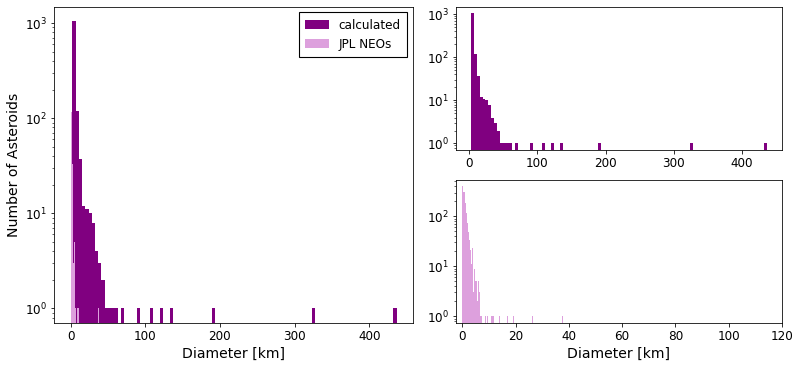

In [78]:
#plotting the different histograms
widths = [1.1, 1]
fig = plt.figure(figsize=(11, 5), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths)

ax0 = fig.add_subplot(spec[:, 0])
                        
ax0.hist(mc_a_diams, bins = 100, color = 'purple', label = 'calculated')
                        
ax0.hist(a_diams, bins = 100, color = "plum", label = 'JPL NEOs')
ax0.set_yscale('log')

ax0.set_xlabel("Diameter [km]")
ax0.set_ylabel("Number of Asteroids")

format_legend()

ax01 = fig.add_subplot(spec[0, 1])
ax01.hist(mc_a_diams, bins = 100, color = 'purple', label = 'calculated')
ax01.set_yscale('log')

ax11 = fig.add_subplot(spec[1, 1])
ax11.hist(a_diams, bins = 100, color = 'plum', label = 'JPL NEOs')
ax11.set_yscale('log')
ax11.set_xlabel("Diameter [km]")
ax11.set_xlim(-2.5, 120)

plt.savefig('montecarlo_figure.jpg', dpi = 900)

### Statistical Analysis
This section obtains the statistical values describing the distribution of asteroids for the Monte Carlo model and the JPL NEOs.

In [79]:
mc_diam_mean = np.mean(mc_a_diams)
mc_diam_std = np.std(mc_a_diams)
print("Monte Carlo Mean Diameter:", "%.2f" % mc_diam_mean, u"\u00B1", "%.2f" % mc_diam_std, "km")

Monte Carlo Mean Diameter: 6.51 ± 18.10 km


In [80]:
mc_diam_max = np.max(mc_a_diams)
mc_diam_min = np.min(mc_a_diams)
print("Monte Carlo Diameters range from:", "%.2f" % mc_diam_min, "to", "%.2f" % mc_diam_max, "km")

Monte Carlo Diameters range from: 2.33 to 436.56 km


In [81]:
jpl_diam_mean = np.mean(a_diams)
jpl_diam_std = np.std(a_diams)
print("JPL NEOs Mean Diameter:", "%.2f" % jpl_diam_mean, u"\u00B1", "%.2f" % jpl_diam_std, "km")

JPL NEOs Mean Diameter: 1.10 ± 1.88 km


In [82]:
jpl_diam_max = np.max(a_diams)
jpl_diam_min = np.min(a_diams)
print("JPL NEOs Diameters range from:", "%.4f" % jpl_diam_min, "to", "%.2f" % jpl_diam_max, "km")

JPL NEOs Diameters range from: 0.0025 to 37.67 km
